# **Задание Pro**

Добейтесь средней точности **91-92%** в задаче поиска мошеннических операций. Для этого попробуйте сделать более мощный автокодировщик и гибкую настройку порога (bias), по которому мы определяем, мошенническая транзакция или нет

Постройте на одном графике **2** гистограммы (density=True) для нормальных и мошеннических транзакций. 

По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы

2) “оптимальный порог” - на пересечении распределений

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

# Подключение библиотек

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from google.colab import drive
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Создание функций

In [ ]:
def getACCByBias(bias, mse_normal, mse_frauds):
  isNormal = mse_normal < bias   # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias   # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal)  # Процент нормальных операций
  accFrauds = sum(isFrauds) / len(isFrauds)  # Процент мошеннических операций

  print("Распознано нормальных транзакций:   ", round(100 * accNormal), "%")
  print("Распознано мошеннических транзакций:", round(100 * accFrauds), "%")
  print("Средняя точность распознавания:     ", round((100 * (accNormal + accFrauds))/ 2), "%")

## Функция создания автокодировщика

In [ ]:
def Autoencoder():

  dataSize = xTrain.shape[1]              # Берем размеры X_train по второй оси - (29)

  dataInput = Input(shape=(dataSize, ))   # и задаем эти размеры как входные в сеть (29, )

  x = Dense(10,activation='relu')(dataInput) 
  x = Dense(dataSize, activation='linear')(x)

  autoencoder = Model(inputs=dataInput, outputs=x)

  autoencoder.compile(optimizer='Adam', loss='mse')

  return autoencoder

In [ ]:
def Autoencoder_2():
  dataInput = Input(shape=(xTrain.shape[1], ))

  x = Dense(128, activation="relu")(dataInput) 
  x = BatchNormalization()(x)
  x = Dense(64, activation="relu")(x) 
  x = BatchNormalization()(x)
  x = Dense(32, activation="relu")(x) 
  x = BatchNormalization()(x)

  z = Dense(10, activation="relu")(x) 
  x = BatchNormalization()(z)

  x = Dense(32, activation="relu")(x) 
  x = BatchNormalization()(x)
  x = Dense(64, activation="relu")(x) 
  x = BatchNormalization()(x)
  x = Dense(128, activation="relu")(x) 
  x = BatchNormalization()(x)

  x = Dense(xTrain.shape[1], activation='linear')(x)
  
  model = Model(inputs=dataInput, outputs=x)
  model.compile(optimizer='Adam', loss='mse')

  return model


# Определение мошеннических операций


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/УИИ/Автокодировщики/База CREDITCARD/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data = df.drop(['Time'], axis=1)  # Удаляем столбец Time

In [ ]:
# Нормализуем столбец с суммой первода
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [ ]:
# Записываем операции: frauds - мошеннические, normal - нормальные
normal = data[data.Class == 0]
frauds = data[data['Class'] == 1]


In [ ]:
print("Мошеннические операции", frauds.shape)
print("Нормальные операции", normal.shape)

Мошеннические операции (492, 30)
Нормальные операции (284315, 30)


In [ ]:
RANDOM_SEED = 10  # Задаем случайное значение

xTrain, xTest = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)


In [ ]:
print("Размер обучающей выборки:", xTrain.shape)
print("Размер тестовой выборки: " , xTest.shape)

Размер обучающей выборки: (227452, 30)
Размер тестовой выборки:  (56863, 30)


In [ ]:
# Удаляем Class в обучающем наборе
xTrain = xTrain.drop(['Class'], axis=1)

In [ ]:
# Добавляем все мошеннические транзакции в тестовый набор данных
xTest = pd.concat([xTest, frauds])
print("Размер тестовой выборки вместе с мошенническими операциями: " , xTest.shape)    # 56863 + 492 = 57355

Размер тестовой выборки вместе с мошенническими операциями:  (57355, 30)


In [ ]:
# Делаем метки(ответы) для тестового набора данных
yTest = xTest['Class']

In [ ]:
# Удаляем класс у тестового набора данных
xTest = xTest.drop(['Class'], axis=1)

In [ ]:
# Преобразуем данные в массивы numpy
xTrain = xTrain.values
xTest = xTest.values

In [ ]:
print("Размер обучающей выборки:", xTrain.shape)
print("Размер тестовой выборки: " , xTest.shape)

Размер обучающей выборки: (227452, 29)
Размер тестовой выборки:  (57355, 29)


# Простая сеть 

In [ ]:
model = Autoencoder()

## Модель сети

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                319       
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________


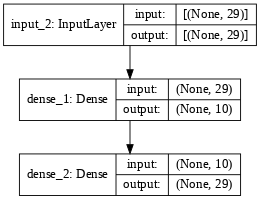

In [ ]:
plot_model(model, dpi=65, show_shapes=True)

## Обучение сети

In [ ]:
# Воспользуемся callback для лучшего обучения (изменения шага обучения)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
historyCreditCard = model.fit(xTrain, xTrain, epochs=100, batch_size=100, callbacks=[reduce_lr])

Epoch 1/100
2275/2275 [==============================] - 3s 954us/step - loss: 0.6016
Epoch 2/100
2275/2275 [==============================] - 2s 938us/step - loss: 0.3816
Epoch 3/100
2275/2275 [==============================] - 2s 938us/step - loss: 0.3687
Epoch 4/100
2275/2275 [==============================] - 2s 934us/step - loss: 0.3657
Epoch 5/100
2275/2275 [==============================] - 2s 952us/step - loss: 0.3601
Epoch 6/100
2275/2275 [==============================] - 2s 946us/step - loss: 0.3560
Epoch 7/100
2275/2275 [==============================] - 2s 928us/step - loss: 0.3552
Epoch 8/100
2275/2275 [==============================] - 2s 957us/step - loss: 0.3547
Epoch 9/100
2275/2275 [==============================] - 2s 947us/step - loss: 0.3547
Epoch 10/100
2275/2275 [==============================] - 2s 933us/step - loss: 0.3546
Epoch 11/100
2275/2275 [==============================] - 2s 958us/step - loss: 0.3546
Epoch 12/100
2275/2275 [============================

In [ ]:
# model.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelCreditPro.h5')
# model.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelCreditPro.h5')

## График обучения

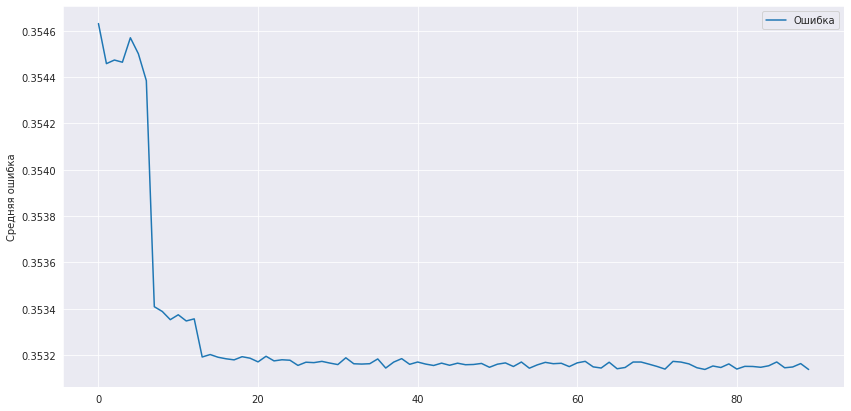

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyCreditCard.history['loss'][10:], label='Ошибка')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат

In [ ]:
# Делаем предикт
pred = model.predict(xTest)

In [ ]:
# Определяем среднеквадратичную ошибку
mse = np.mean(np.power(xTest-pred, 2), axis=1) 

In [ ]:
mse_normal = mse[yTest.values == 0]   # Через маску найдем среднеквадратичную ошибку на нормальных операциях
mse_frauds = mse[yTest.values == 1]   # Через маску найдем среднеквадратичную ошибку на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций: ", round(min(mse_normal), 4)) 
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal), 4)) 
print("Средняя ошибка нормальных транзакций:     ", round(sum(mse_normal) / len(mse_normal), 4)) 

Минимальная ошибка нормальных транзакций:  0.0432
Максимальная ошибка нормальных транзакций: 87.0871
Средняя ошибка нормальных транзакций:      0.3502


In [ ]:
print("Минимальная ошибка мошеннических транзакций: ", round(min(mse_frauds),4))
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) 
print("Средняя ошибка мошеннических транзакций:     ", round(sum(mse_frauds) / len(mse_frauds),4)) 

Минимальная ошибка мошеннических транзакций:  0.1578
Максимальная ошибка мошеннических транзакций: 94.1654
Средняя ошибка мошеннических транзакций:      18.7449


In [ ]:
#  Расставим значения на числовой прямой

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#     0.043     0.157     0.3502    18.74      87.08    94.16
#   ----x---------x---------x---------x----------x--------x----->

**Попробуем разное пороговое значение**

In [ ]:
getACCByBias(0.65, mse_normal, mse_frauds)

Распознано нормальных транзакций:    93 %
Распознано мошеннических транзакций: 89 %
Средняя точность распознавания:      91 %


In [ ]:
getACCByBias(0.7, mse_normal, mse_frauds)

Распознано нормальных транзакций:    94 %
Распознано мошеннических транзакций: 89 %
Средняя точность распознавания:      91 %


In [ ]:
getACCByBias(0.6, mse_normal, mse_frauds)

Распознано нормальных транзакций:    91 %
Распознано мошеннических транзакций: 91 %
Средняя точность распознавания:      91 %


In [ ]:
getACCByBias(0.8, mse_normal, mse_frauds)

Распознано нормальных транзакций:    96 %
Распознано мошеннических транзакций: 88 %
Средняя точность распознавания:      92 %


In [ ]:
getACCByBias(0.85, mse_normal, mse_frauds)

Распознано нормальных транзакций:    97 %
Распознано мошеннических транзакций: 87 %
Средняя точность распознавания:      92 %


In [ ]:
getACCByBias(0.9, mse_normal, mse_frauds)

Распознано нормальных транзакций:    97 %
Распознано мошеннических транзакций: 87 %
Средняя точность распознавания:      92 %


In [ ]:
getACCByBias(1.5, mse_normal, mse_frauds)

Распознано нормальных транзакций:    99 %
Распознано мошеннических транзакций: 86 %
Средняя точность распознавания:      92 %


**Средняя точность при разных значениях Bias в районе 91-92%**

# Задание 2

Постройте на одном графике **2** гистограммы (density=True) для нормальных и мошеннических транзакций.

  - По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы

2) “оптимальный порог” - на пересечении распределений

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

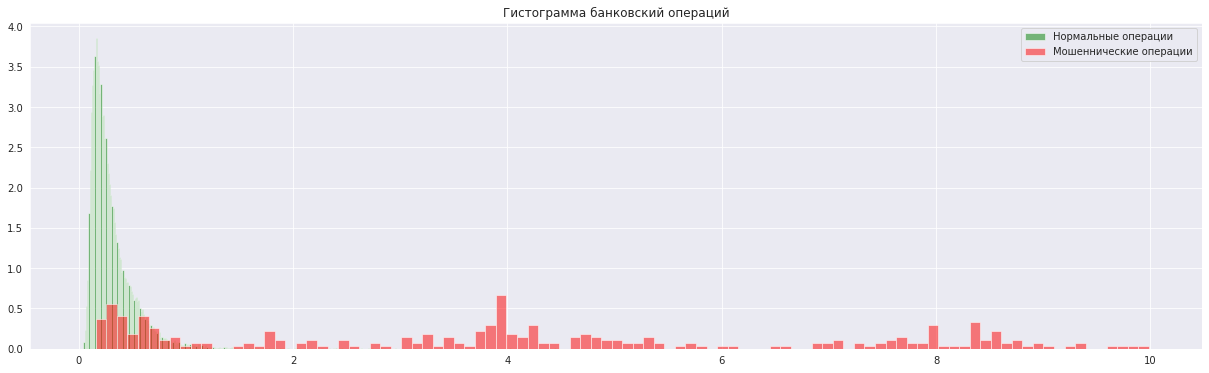

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal[mse_normal<10],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds[mse_frauds<10],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

**Если взять значения до 1(приблизить график в этой области)**

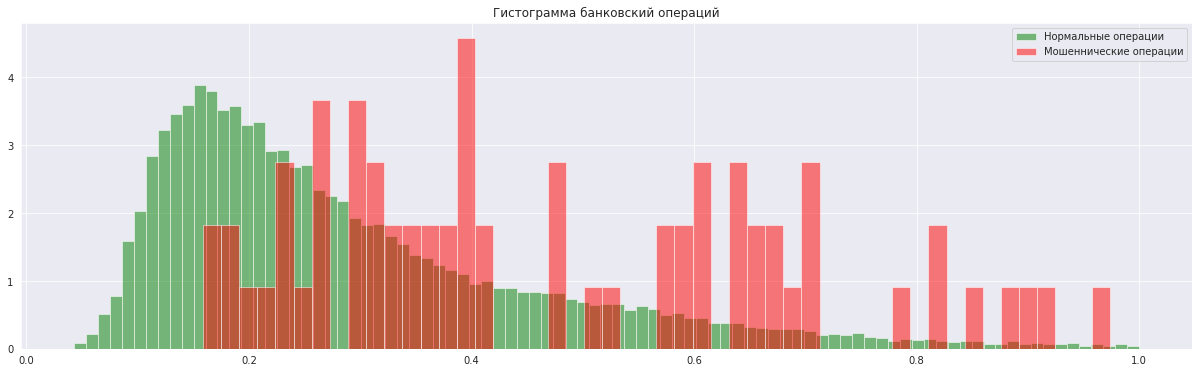

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal[mse_normal<1],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds[mse_frauds<1],bins=50, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

In [ ]:
getACCByBias(0.175)

Распознано нормальных транзакций:    29 %
Распознано мошеннических транзакций: 100 %
Средняя точность распознавания:      64 %


In [ ]:
getACCByBias(0.8)

Распознано нормальных транзакций:    96 %
Распознано мошеннических транзакций: 88 %
Средняя точность распознавания:      92 %


In [ ]:
getACCByBias(80.3)

Распознано нормальных транзакций:    100 %
Распознано мошеннических транзакций: 0 %
Средняя точность распознавания:      50 %


По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы : **0.175**

2) “оптимальный порог” - на пересечении распределений: **0.8**

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая: **80.3**

# Для улучшения значений попробуем обучить более сложную сеть

In [ ]:
model_2 = Autoencoder_2()

## Модель сети

In [ ]:
model_2.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               3840      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128)               512       
_________________________________________________________________
dense_72 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64)                256       
_________________________________________________________________
dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32)                128

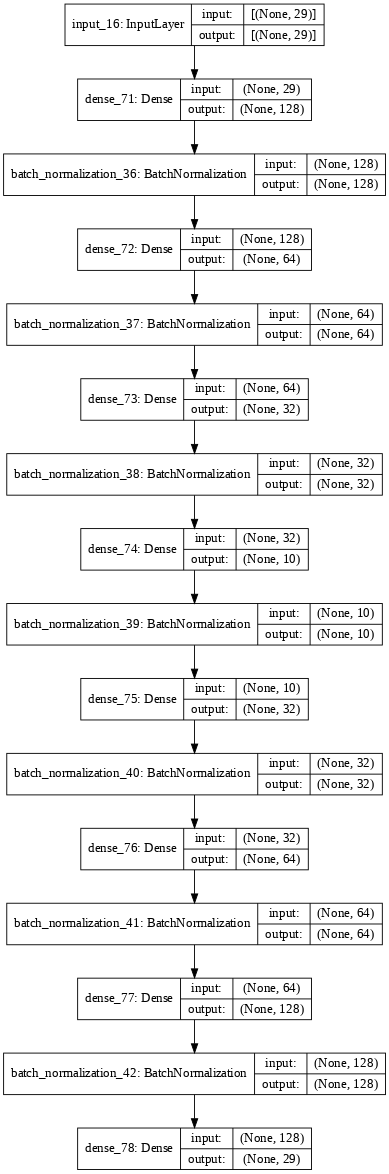

In [ ]:
plot_model(model_2, dpi=65, show_shapes=True)

## Обучение сети

In [ ]:
historyCreditCard_2= model_2.fit(xTrain, xTrain, epochs=100, batch_size=200, callbacks=[reduce_lr])

Epoch 1/100
1138/1138 [==============================] - 9s 6ms/step - loss: 0.4231
Epoch 2/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.2195
Epoch 3/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1655
Epoch 4/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1436
Epoch 5/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1294
Epoch 6/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1207
Epoch 7/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1141
Epoch 8/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1100
Epoch 9/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1045
Epoch 10/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.1021
Epoch 11/100
1138/1138 [==============================] - 7s 6ms/step - loss: 0.0984
Epoch 12/100
1138/1138 [==============================] - 7s 6ms/step - lo

In [ ]:
model.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_2CreditPro.h5')
# model.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_2CreditPro.h5')

## График обучения

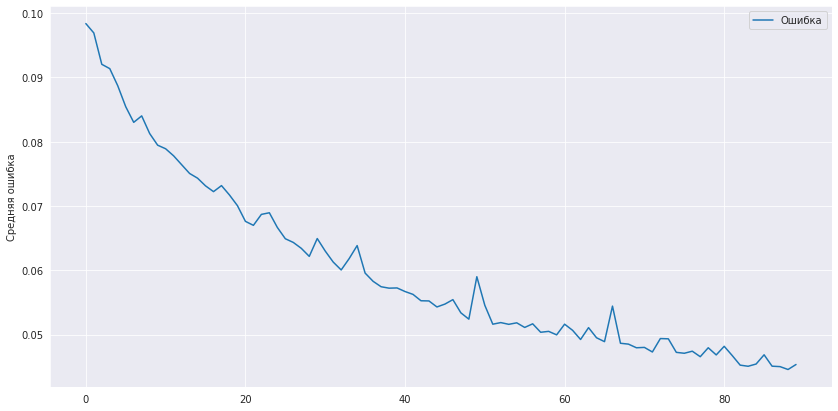

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyCreditCard_2.history['loss'][10:], label='Ошибка')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат

In [ ]:
# Делаем предикт
pred_2 = model_2.predict(xTest)

In [ ]:
# Определяем среднеквадратичную ошибку
mse_2 = np.mean(np.power(xTest-pred_2, 2), axis=1) 

In [ ]:
mse_normal_2 = mse_2[yTest.values == 0]   # Через маску найдем среднеквадратичную ошибку на нормальных операциях
mse_frauds_2 = mse_2[yTest.values == 1]   # Через маску найдем среднеквадратичную ошибку на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций: ", round(min(mse_normal_2), 4)) 
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal_2), 4)) 
print("Средняя ошибка нормальных транзакций:     ", round(sum(mse_normal_2) / len(mse_normal_2), 4)) 

Минимальная ошибка нормальных транзакций:  0.0011
Максимальная ошибка нормальных транзакций: 55.2926
Средняя ошибка нормальных транзакций:      0.0351


In [ ]:
print("Минимальная ошибка мошеннических транзакций: ", round(min(mse_frauds_2),4))
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds_2),4)) 
print("Средняя ошибка мошеннических транзакций:     ", round(sum(mse_frauds_2) / len(mse_frauds_2),4)) 

Минимальная ошибка мошеннических транзакций:  0.0021
Максимальная ошибка мошеннических транзакций: 60.4232
Средняя ошибка мошеннических транзакций:      3.5339


In [ ]:
#  Прошлый результат(простая сеть)  loss: 0.3531

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#     0.043     0.157     0.3502    18.74      87.08    94.16
#   ----x---------x---------x---------x----------x--------x----->

In [ ]:
#  Данный результат(сложная сеть)  loss: 0.0453

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#     0.0011   0.0021     0.0351    3.53       55.29    60.42
#   ----x---------x---------x---------x----------x--------x----->

## Гистограмма для данной сети

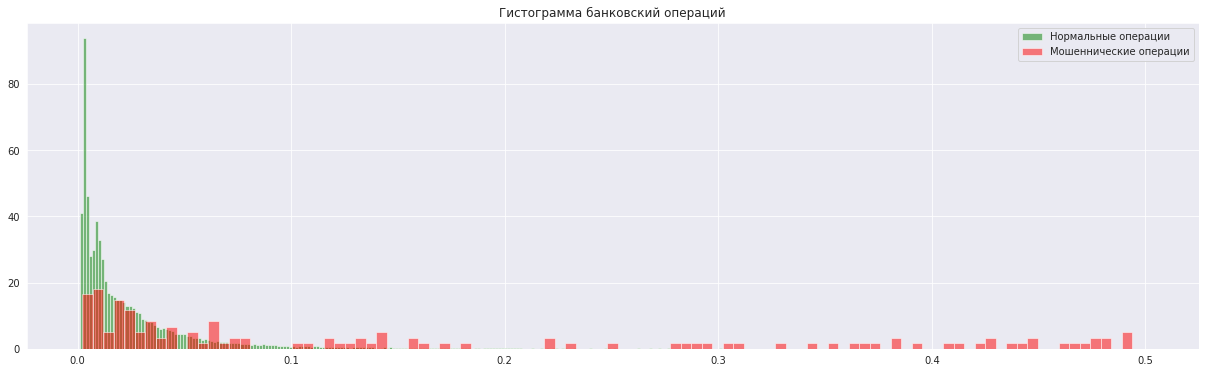

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal_2[mse_normal_2<0.5],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds_2[mse_frauds_2<0.5],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

**На гистограмме видно что значение нормальных операция и мошеннических практически перекрывают друг друга.**

   **- Сделаем масштам меньше значения 0.1**

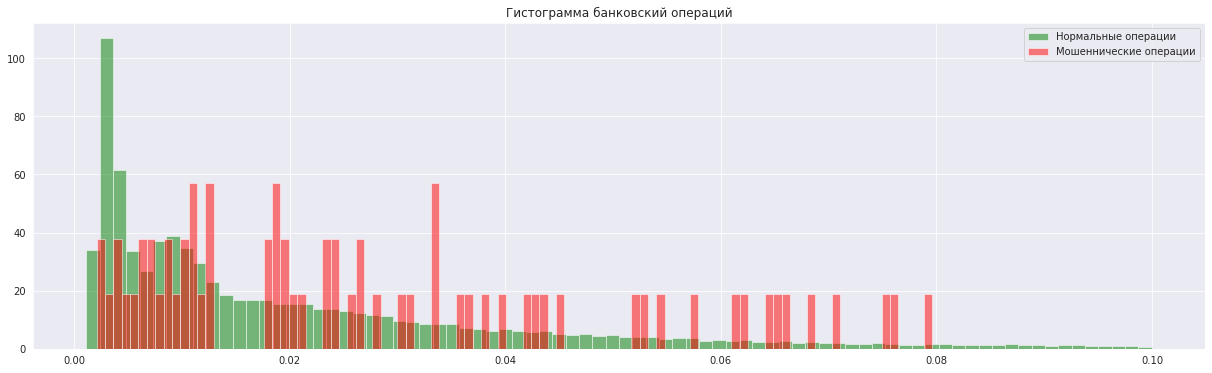

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal_2[mse_normal_2<0.1],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds_2[mse_frauds_2<0.1],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

**Попробуем разное пороговое значение**

In [ ]:
getACCByBias(0.09, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    94 %
Распознано мошеннических транзакций: 86 %
Средняя точность распознавания:      90 %


In [ ]:
getACCByBias(0.085, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    93 %
Распознано мошеннических транзакций: 86 %
Средняя точность распознавания:      90 %


In [ ]:
getACCByBias(0.02, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    60 %
Распознано мошеннических транзакций: 94 %
Средняя точность распознавания:      77 %


**При данных значениях среднюю точность больше 90% добиться не получится.**

По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы : **0.0031**

2) “оптимальный порог” - на пересечении распределений: **0.1**

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая: **42.77**

In [ ]:
getACCByBias(0.0031, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    12 %
Распознано мошеннических транзакций: 100 %
Средняя точность распознавания:      56 %


In [ ]:
getACCByBias(0.1, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    95 %
Распознано мошеннических транзакций: 86 %
Средняя точность распознавания:      90 %


In [ ]:
getACCByBias(42.77, mse_normal_2, mse_frauds_2)

Распознано нормальных транзакций:    100 %
Распознано мошеннических транзакций: 0 %
Средняя точность распознавания:      50 %


**Как видно результат хуже чем на более простой архитектуре сети**

**Попбробуем сделать тоже самое но с нормированными данными. Две сети будут точно такими же.** 

#  С нормированными входными данными

In [ ]:
xTrainNorm = normalize(xTrain)
xTestNorm = normalize(xTest)

## На простой сети

In [ ]:
model_3_Normalize = Autoencoder()

In [ ]:
historyCreditCard_3_Normalize = model_3_Normalize.fit(xTrainNorm, xTrainNorm, epochs=100, batch_size=100, callbacks=[reduce_lr])

Epoch 1/100
2275/2275 [==============================] - 4s 1ms/step - loss: 0.0140
Epoch 2/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0103
Epoch 3/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 4/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 5/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 6/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 7/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 8/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 9/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 10/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 11/100
2275/2275 [==============================] - 3s 1ms/step - loss: 0.0102
Epoch 12/100
2275/2275 [==============================] - 3s 1ms/step - lo

In [ ]:
# model.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_3_Normalize_CreditPro.h5')
# model.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_3_Normalize_CreditPro.h5')

## График обучения

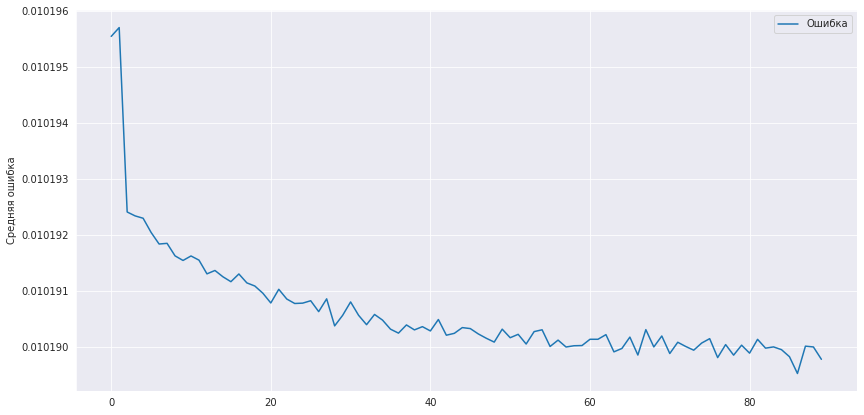

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyCreditCard_3_Normalize.history['loss'][10:], label='Ошибка')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат

In [ ]:
# Делаем предикт
pred_3_Normalize = model_3_Normalize.predict(xTestNorm)

In [ ]:
# Определяем среднеквадратичную ошибку
mse_3_Normalize = np.mean(np.power(xTestNorm-pred_3_Normalize, 2), axis=1) 

In [ ]:
mse_normal_3_Normalize = mse_3_Normalize[yTest.values == 0]   # Через маску найдем среднеквадратичную ошибку на нормальных операциях
mse_frauds_3_Normalize = mse_3_Normalize[yTest.values == 1]   # Через маску найдем среднеквадратичную ошибку на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций: ", round(min(mse_normal_3_Normalize), 4)) 
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal_3_Normalize), 4)) 
print("Средняя ошибка нормальных транзакций:     ", round(sum(mse_normal_3_Normalize) / len(mse_normal_3_Normalize), 4)) 

Минимальная ошибка нормальных транзакций:  0.0005
Максимальная ошибка нормальных транзакций: 0.0354
Средняя ошибка нормальных транзакций:      0.0102


In [ ]:
print("Минимальная ошибка мошеннических транзакций: ", round(min(mse_frauds_3_Normalize),4))
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds_3_Normalize),4)) 
print("Средняя ошибка мошеннических транзакций:     ", round(sum(mse_frauds_3_Normalize) / len(mse_frauds_3_Normalize),4)) 

Минимальная ошибка мошеннических транзакций:  0.0022
Максимальная ошибка мошеннических транзакций: 0.0352
Средняя ошибка мошеннических транзакций:      0.0297


In [ ]:
#  Расставим значения на числовой прямой

#      MinN      MinF      MeanN     MeanF      MaxF      MaxN
#     0.0005    0.0022     0.0102    0.0297    0.0354    0.0352
#   ----x---------x---------x---------x----------x--------x----->

**Попробуем разное пороговое значение**

In [ ]:
getACCByBias(0.025, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    96 %
Распознано мошеннических транзакций: 86 %
Средняя точность распознавания:      91 %


In [ ]:
getACCByBias(0.024, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    95 %
Распознано мошеннических транзакций: 87 %
Средняя точность распознавания:      91 %


In [ ]:
getACCByBias(0.023, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    94 %
Распознано мошеннических транзакций: 87 %
Средняя точность распознавания:      91 %


## Гистограмма для данной сети

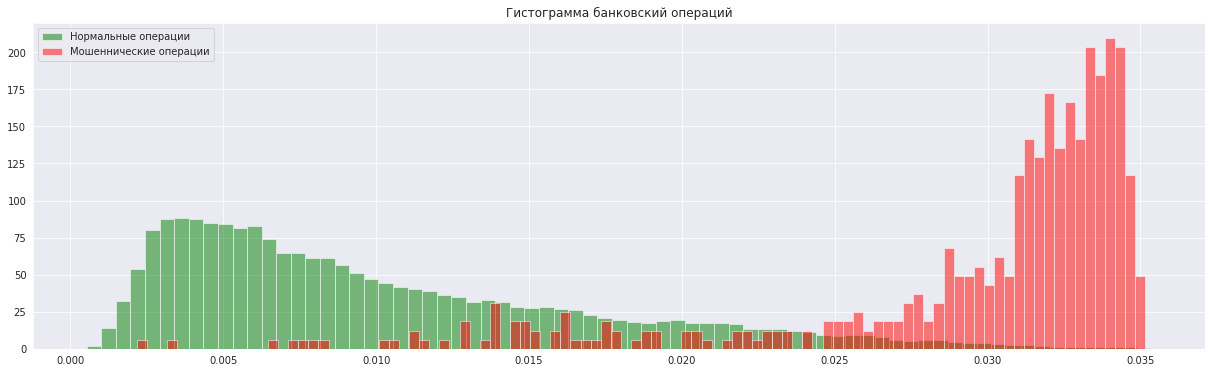

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal_3_Normalize[mse_normal_3_Normalize<0.1],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds_3_Normalize[mse_frauds_3_Normalize<0.1],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы : **0.0035**

2) “оптимальный порог” - на пересечении распределений: **0.25**

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая: **0.035**

In [ ]:
getACCByBias(0.0035, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    14 %
Распознано мошеннических транзакций: 100 %
Средняя точность распознавания:      57 %


In [ ]:
getACCByBias(0.0025, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    5 %
Распознано мошеннических транзакций: 100 %
Средняя точность распознавания:      53 %


In [ ]:
getACCByBias(0.35, mse_normal_3_Normalize, mse_frauds_3_Normalize)

Распознано нормальных транзакций:    100 %
Распознано мошеннических транзакций: 0 %
Средняя точность распознавания:      50 %


# Сложная сеть с нормированными данными

In [ ]:
model_4_Normalize = Autoencoder_2()

## Обучение сети

In [ ]:
historyCreditCard_4_Normalize = model_4_Normalize.fit(xTrainNorm, xTrainNorm, epochs=100, batch_size=100, callbacks=[reduce_lr])

Epoch 1/100
2275/2275 [==============================] - 11s 4ms/step - loss: 0.0321
Epoch 2/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0118
Epoch 3/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0080
Epoch 4/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0061
Epoch 5/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0048
Epoch 6/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0041
Epoch 7/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0037
Epoch 8/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0034
Epoch 9/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0032
Epoch 10/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0031
Epoch 11/100
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0029
Epoch 12/100
2275/2275 [==============================] - 9s 4ms/step - l

In [ ]:
# model.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_4_Normalize_CreditPro.h5')
# model.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/model_4_Normalize_CreditPro.h5')

## График обучения

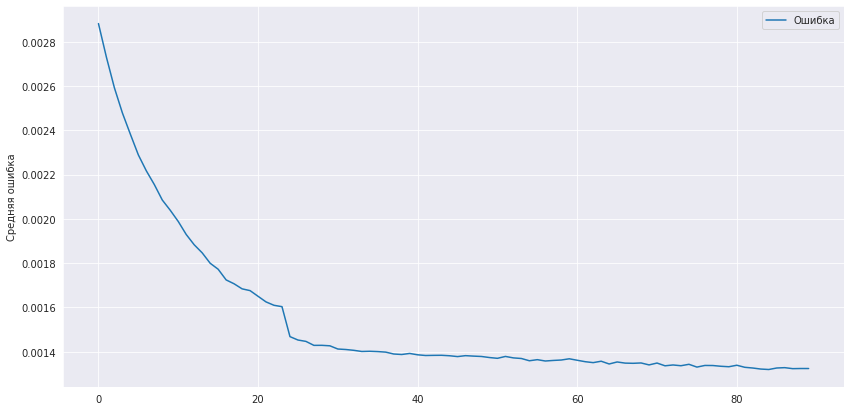

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyCreditCard_4_Normalize.history['loss'][10:], label='Ошибка')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат

In [ ]:
# Делаем предикт
pred_4_Normalize = model_4_Normalize.predict(xTestNorm)

In [ ]:
# Определяем среднеквадратичную ошибку
mse_4_Normalize = np.mean(np.power(xTestNorm-pred_4_Normalize, 2), axis=1) 

In [ ]:
mse_normal_4_Normalize = mse_4_Normalize[yTest.values == 0]   # Через маску найдем среднеквадратичную ошибку на нормальных операциях
mse_frauds_4_Normalize = mse_4_Normalize[yTest.values == 1]   # Через маску найдем среднеквадратичную ошибку на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций: ", round(min(mse_normal_4_Normalize), 4)) 
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal_4_Normalize), 4)) 
print("Средняя ошибка нормальных транзакций:     ", round(sum(mse_normal_4_Normalize) / len(mse_normal_4_Normalize), 4)) 

Минимальная ошибка нормальных транзакций:  0.0
Максимальная ошибка нормальных транзакций: 0.0417
Средняя ошибка нормальных транзакций:      0.0007


In [ ]:
print("Минимальная ошибка мошеннических транзакций: ", round(min(mse_frauds_4_Normalize),4))
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds_4_Normalize),4)) 
print("Средняя ошибка мошеннических транзакций:     ", round(sum(mse_frauds_4_Normalize) / len(mse_frauds_4_Normalize),4)) 

Минимальная ошибка мошеннических транзакций:  0.0
Максимальная ошибка мошеннических транзакций: 0.0688
Средняя ошибка мошеннических транзакций:      0.0161


In [ ]:
#  Расставим значения на числовой прямой

#      MinN      MinF      MeanN     MeanF      MaxN      MaxF
#      0.0       0.0       0.0007    0.016     0.041     0.068
#   ----x---------x---------x---------x----------x--------x----->

**Попробуем разное пороговое значение**

In [ ]:
getACCByBias(0.002, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    91 %
Распознано мошеннических транзакций: 85 %
Средняя точность распознавания:      88 %


In [ ]:
getACCByBias(0.005, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    99 %
Распознано мошеннических транзакций: 81 %
Средняя точность распознавания:      90 %


In [ ]:
getACCByBias(0.006, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    99 %
Распознано мошеннических транзакций: 80 %
Средняя точность распознавания:      90 %


## Гистограмма для данной сети

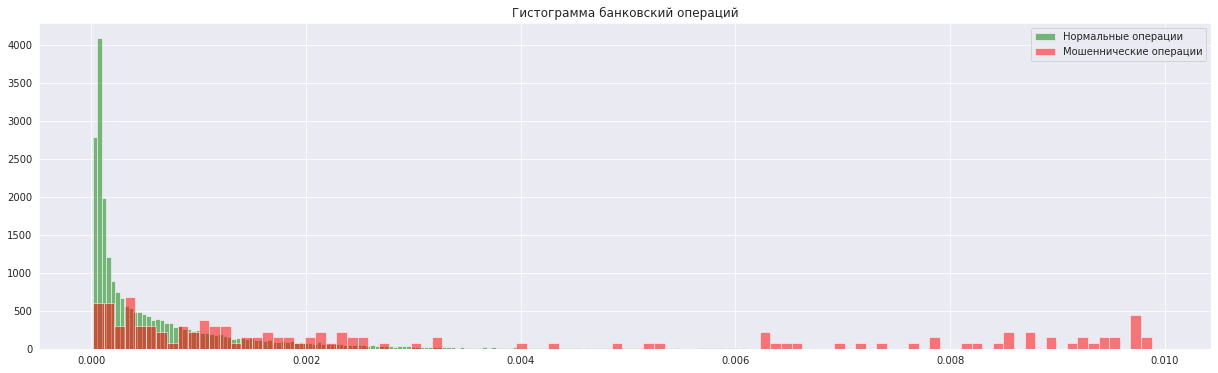

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal_4_Normalize[mse_normal_4_Normalize<0.01],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds_4_Normalize[mse_frauds_4_Normalize<0.01],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

**Приблизим участок значения которых меньше 0.002**

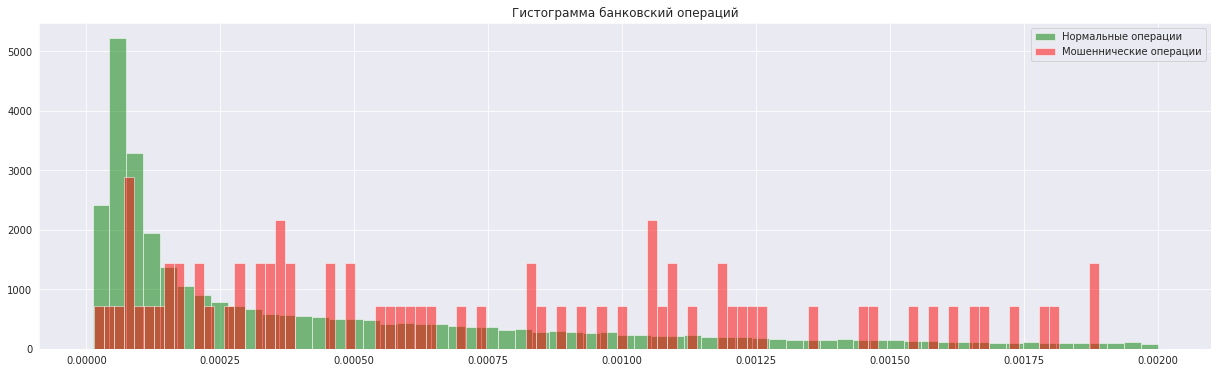

In [ ]:
plt.figure(figsize=(21,6))
plt.hist(mse_normal_4_Normalize[mse_normal_4_Normalize<0.002],bins='auto', color='g',density=True, alpha=0.5, label='Нормальные операции') 
plt.hist(mse_frauds_4_Normalize[mse_frauds_4_Normalize<0.002],bins=100, color='r',density=True, alpha=0.5, label='Мошеннические операции') 
plt.title('Гистограмма банковский операций')
plt.legend()
plt.show()

По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы : **0.00**

2) “оптимальный порог” - на пересечении распределений: **0.005**

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая: **0.061**

In [ ]:
getACCByBias(0.0, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    0 %
Распознано мошеннических транзакций: 100 %
Средняя точность распознавания:      50 %


In [ ]:
getACCByBias(0.005, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    99 %
Распознано мошеннических транзакций: 81 %
Средняя точность распознавания:      90 %


In [ ]:
getACCByBias(0.061, mse_normal_4_Normalize, mse_frauds_4_Normalize)

Распознано нормальных транзакций:    100 %
Распознано мошеннических транзакций: 0 %
Средняя точность распознавания:      50 %


# Выводы: 

In [ ]:
#  Простая сеть

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#     0.043     0.157     0.3502    18.74      87.08    94.16
#   ----x---------x---------x---------x----------x--------x----->

#  Сложная сеть

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#     0.0011   0.0021     0.0351    3.53       55.29    60.42
#   ----x---------x---------x---------x----------x--------x----->


#  Простая сеть с нормированными данными

#      MinN      MinF      MeanN     MeanF      MaxF      MaxN
#     0.0005    0.0022     0.0102    0.0297    0.0354    0.0352
#   ----x---------x---------x---------x----------x--------x----->


#  Сложная сеть с нормированными данными

#      MinN      MinF      MeanN     MeanF      MaxN      MaxF
#      0.0       0.0       0.0007    0.016     0.041     0.068
#   ----x---------x---------x---------x----------x--------x----->

1. При первом рассмотрении кажется что усложнение архитектуры сети, а так же нормированние данных приводит к лучшим результатам:
   - Уменьшается средняя ошибка на нормальных транзакциях
   - На мошеннических так же средняя ошибка стремиться к **0**

2. Но при этом самая простая нейронная сеть состоящая из одного скрытого слоя показывает результат не хуже, а даже лучше во всех представленных экспериментах.

3. С помощью гистограмм визуально видно, что на простой сети оба графика(нормальных и мошеннических транзакций) пересекаются в определенной точке. Но чем сложнее сеть тем больше два графика перекрывают друг друга. 
   Это же видно при обучении на нормированных данных.

4. При использовании более сложный нейронных сетей невозможно добиться поставленной задачи в **91-92 %**. Данная задача была достигнута применяя самую простую архитектуру. 

5. При решении определенных задач лучше идти от простого к сложному, а не наоборот. 

6. Для оценки результата хорошей практикой будет применят не только математические формулы, как нахождения среднеквадратичной ошибки и другие, но и визуализировать результат. 